## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
pip install plotly


Note: you may need to restart the kernel to use updated packages.


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

2023-07-11 16:45:33.625666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 


# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
 

  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
df[['_source.complaint_what_happened','_source.product']]

,_source.complaint_what_happened,_source.product
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card
...,...,...
78308,,Checking or savings account
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card
78310,I am not familiar with XXXX pay and did not un...,Checking or savings account
78311,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card


In [7]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [8]:
#Assign nan in place of blanks in the complaints column
df = df[['complaints_what_happened', 'tag']]
df.sample(10)

,complaints_what_happened,tag
27492,,Credit card
15298,Chase Bank ( www.chase.com ) website states th...,Credit card or prepaid card
42938,I have had a long going history with Chase for...,Credit card or prepaid card
16074,,Mortgage
57683,,Credit card or prepaid card
6127,"Upon receiving my recent Credit report, I have...",Debt collection
33599,,Credit card or prepaid card
6815,,"Credit reporting, credit repair services, or o..."
5511,,Vehicle loan or lease
7345,,Credit card or prepaid card


In [9]:
#Remove all rows where complaints column is nan
print("Before: {}".format(df.shape))
df = df[df['complaints_what_happened'].astype(bool)]
print("After: {}".format(df.shape))

Before: (78313, 2)
After: (21072, 2)


In [10]:
df['complaints_what_happened'].isnull()

1        False
2        False
10       False
11       False
14       False
         ...  
78303    False
78309    False
78310    False
78311    False
78312    False
Name: complaints_what_happened, Length: 21072, dtype: bool

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
#Write your function to Lemmatize the texts

import re
import pandas as pd
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

def clean_and_process_text(df, text_column):
    # Remove blank complaints
    df = df[df[text_column].str.strip() != ""].copy()
    
    # Make lowercase
    df['complaints'] = df[text_column].str.lower()
    
    # Remove text in square brackets
    df['complaints'] = df[text_column].str.replace(r'\[.*?\]', '', regex=True)
    
    # Remove punctuation
    df['complaints'] = df[text_column].str.replace(r'[^\w\s]', '', regex=True)
    
    # Remove words containing numbers
    df['complaints'] = df[text_column].apply(lambda text: ' '.join(word for word in text.split() if not any(c.isdigit() for c in word)))
    
    # Lemmatize the texts
    lemmatizer = WordNetLemmatizer()
    df['complaints'] = df[text_column].apply(lambda text: ' '.join(lemmatizer.lemmatize(word) for word in text.split()))
    
    # Extract nouns
    df['complaints'] = df[text_column].apply(lambda text: ' '.join(word for word, tag in pos_tag(text.split()) if tag.startswith('NN')))
    
    return df

In [12]:

import nltk
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/monu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
df_processed = clean_and_process_text(df, 'complaints_what_happened')

In [14]:
df_processed.sample(10)

,complaints_what_happened,tag,complaints
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,XXXX card XX/XX/2018 agent upgrade date agent ...
20355,I have been writing letters to Chase Bank stat...,Debt collection,letters Chase Bank credit report debt letters ...
62360,"This is a report on my XXXX credit card, like ...",Credit card,"report XXXX credit card, XXXX payment card mon..."
6425,"I placed an order from XXXX for {$2600.00}, on...",Credit card or prepaid card,"order XXXX {$2600.00}, XXXX XXXX. week order, ..."
15540,My car was repossessed on XXXX/XXXX/2016 by Ch...,Consumer Loan,car XXXX/XXXX/2016 Chase Bank. XXXX/XXXX/2016 ...
70778,JP Morgan Chase Bank has locked out the proper...,Mortgage,"JP Morgan Chase Bank property XXXX XXXX XXXX, ..."
17272,I am a customer with Chase bank and on Sunday ...,Checking or savings account,customer Chase bank Sunday XXXX XXXX transacti...
4306,I was charged for two purchases from Amazon th...,Credit card or prepaid card,purchases Amazon item toolkit {$32.00} XX/XX/X...
33705,They call at least 5 times a day and at all ho...,Debt collection,"times day hours day. Today XX/XX/26, calls XXXX"
57128,I have been comparing credit card offers and c...,Credit card or prepaid card,credit card offers Chase Sapphire Reserve card...


In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df_processed[['complaints_what_happened' , 'complaints']]

In [16]:
df_clean.head()

,complaints_what_happened,complaints
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card XX/XX/2019. However, application id..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","XX/XX/2018, book XXXX XXXX ticket, offer {$300..."
14,my grand son give me check for {$1600.00} i de...,son {$1600.00} deposit chase account fund chas...


In [17]:
#Write your function to extract the POS tags 

def pos_tag(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['complaints']), axis=1)




#df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [18]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(1)

,complaints_what_happened,complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...


In [19]:
df_clean.head(1).values

array([['Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.',
        'morning name XXXX XXXX stop Chase Bank cardmember services. Chase debt verification statement bank debt. mail month debt. right information Chase account XXXX XXXX XXXX XXXX Thanks advance help.',
        'morning name xxxx cardmember chase debt verification statement bank debt mail month debt information account xxxx xxxx xxxx xxxx advance help']],
      dtype=object)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [22]:
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:10]

[141, 97, 54, 333, 114, 7, 393, 383, 733, 43]

Text(0, 0.5, 'No. of Complaints')

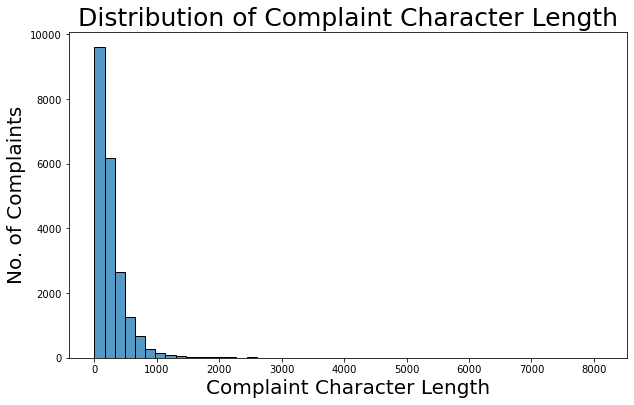

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

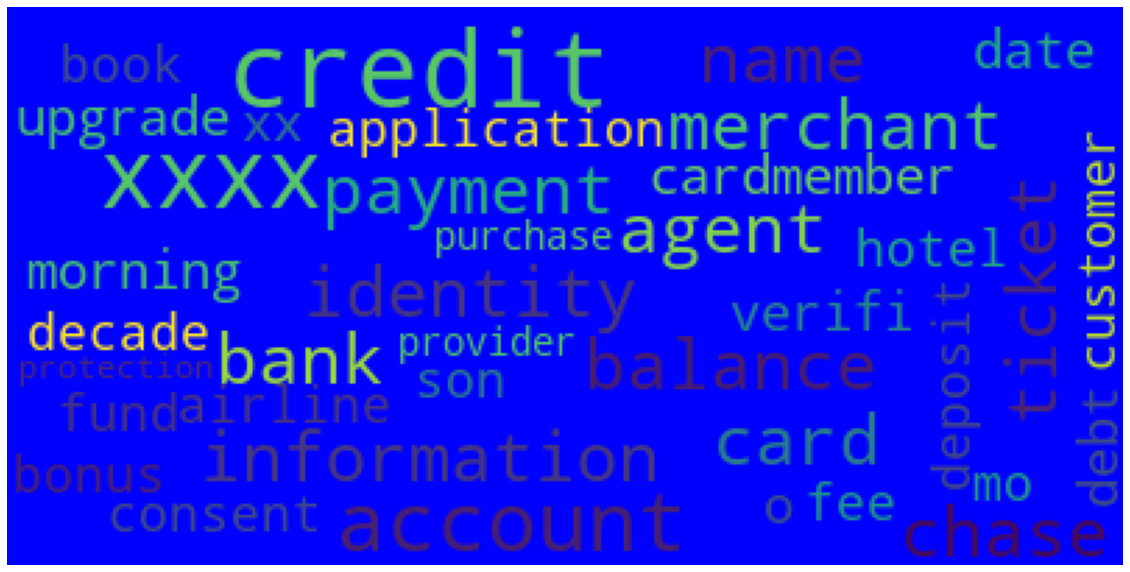

In [25]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [26]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [27]:
df_clean['Complaint_clean']

1        morning name xxxx cardmember chase debt verifi...
2        card xx agent upgrade date agent information o...
10       application identity consent credit identity a...
11       book xxxx xxxx ticket ticket card information ...
14       son deposit chase account fund bank account mo...
                               ...                        
78303    customer decade credit bonus airline hotel fee...
78309    xxxx provider purchase protection benefit scho...
78310    risk bank app banking merchant merchant websit...
78311    credit credit balance life experience balance ...
78312    order line credit account payment payment cred...
Name: Complaint_clean, Length: 21072, dtype: object

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [55]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
import sys 
def get_top_ngram(text, n=30,gram=None):
    #print(gram)
    if not gram:
        vector = CountVectorizer(stop_words='english').fit(text)
    elif gram == 2:
        vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    elif gram == 3:
        vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    else:
        sys.exit("gram parameter can accept 'None/1 or 2'")
    #vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)   
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]



In [54]:
#Print the top 10 words in the unigram frequency

top_common_words = get_top_ngram(df_clean['complaint_POS_removed'].values.astype('U'),gram=None)
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

None


,unigram,count
0,xxxx,95639
1,account,31070
2,credit,29137
3,card,22731
4,bank,13375
5,payment,13225
6,money,11316
7,time,11192
8,information,8931
9,loan,8648


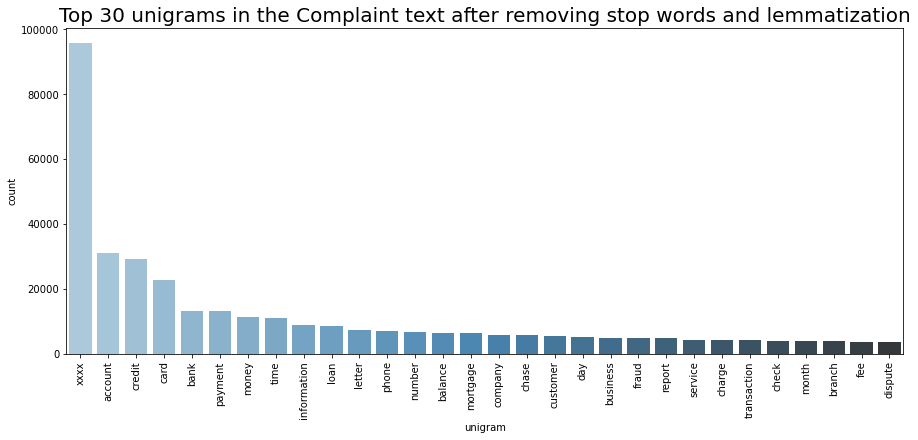

In [56]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [57]:
#Print the top 10 words in the bigram frequency
top_biagram_common_words = get_top_ngram(df_clean['complaint_POS_removed'].values.astype('U'),gram=2)
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,xxxx xxxx,45076
1,credit card,9543
2,credit report,2939
3,account account,2484
4,customer service,2446
5,account xxxx,2421
6,xxxx account,2336
7,xxxx credit,2301
8,card xxxx,2040
9,xx 2020,1763


In [59]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_common_words = get_top_ngram(df_clean['complaint_POS_removed'].values.astype('U'),gram=3)


,trigram,count
0,xxxx xxxx xxxx,26562
1,xxxx credit card,954
2,credit card xxxx,834
3,xxxx xxxx account,824
4,account xxxx xxxx,820
5,xxxx xxxx credit,751
6,credit card account,731
7,credit card company,726
8,credit card credit,709
9,card xxxx xxxx,656


In [60]:
#Print the top 10 words in the trigram frequency

df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,26562
1,xxxx credit card,954
2,credit card xxxx,834
3,xxxx xxxx account,824
4,account xxxx xxxx,820
5,xxxx xxxx credit,751
6,credit card account,731
7,credit card company,726
8,credit card credit,709
9,card xxxx xxxx,656


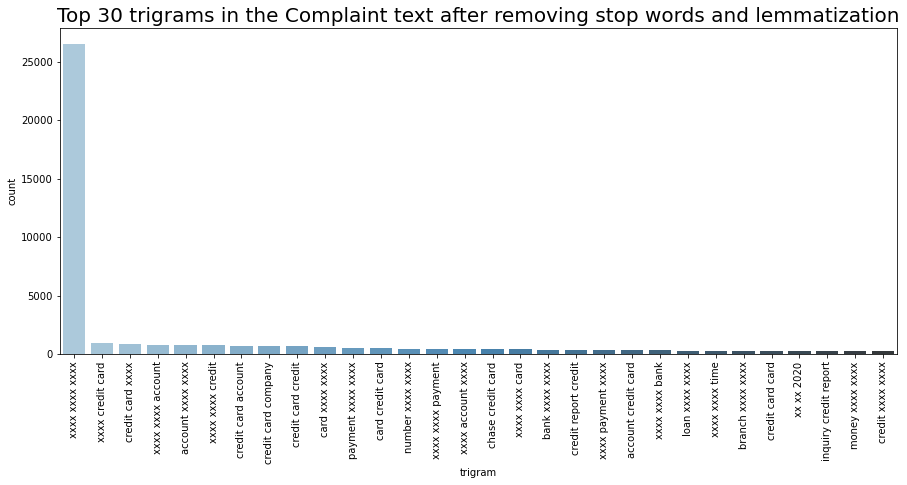

In [61]:
# Plot the top 30 triagram
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [62]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [63]:
#All masked texts has been removed
df_clean

,complaints_what_happened,complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...,morning name cardmember chase debt verificati...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card XX/XX/2019. However, application id...",application identity consent credit identity a...,application identity consent credit identity a...
11,"On XX/XX/2018, while trying to book a XXXX XX...","XX/XX/2018, book XXXX XXXX ticket, offer {$300...",book xxxx xxxx ticket ticket card information ...,book ticket ticket card information minute s...
14,my grand son give me check for {$1600.00} i de...,son {$1600.00} deposit chase account fund chas...,son deposit chase account fund bank account mo...,son deposit chase account fund bank account mo...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"Chase Card customer decade, solicitations cred...",customer decade credit bonus airline hotel fee...,customer decade credit bonus airline hotel fee...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","Wednesday, XX/XX/XXXX Chas, XXXX XXXX Visa Cre...",xxxx provider purchase protection benefit scho...,provider purchase protection benefit school y...
78310,I am not familiar with XXXX pay and did not un...,pay risk Chase bank app. Chase years mobile ba...,risk bank app banking merchant merchant websit...,risk bank app banking merchant merchant websit...
78311,I have had flawless credit for 30 yrs. I've ha...,"credit yrs. I've Chase credit cards, Chase Fre...",credit credit balance life experience balance ...,credit credit balance life experience balance ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [70]:
#Write your code here to initialise the TfidfVectorizer 


df_cleaner=df_clean.copy()
df_clean=df_cleaner.copy()
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [71]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [66]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [67]:
#Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
data_set = [x.split() for x in texts]

# Creating a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(data_set)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data_set]

# Create a list of the topic numbers we want to try
topic_num = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

/Users/monu/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/monu/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in double_scalars



5


In [68]:
df_clean.shape

(21072, 4)

In [ ]:
#Load your nmf_model with the n_components i.e 5
#num_topics = #write the value you want to test out

#keep the random_state =40
#nmf_model = #write your code here

In [76]:
nmf_model = NMF(n_components=5,random_state=40)
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

4327

In [80]:
#Print the Top15 words for each of the topics
topic_single = nmf_model.components_[0]
topic_single.argsort()
top_word_index = topic_single.argsort()[-15:]
for index in top_word_index:
    print(tfidf.get_feature_names_out()[index])

    


company
debt
complaint
fraud
address
transaction
email
charge
case
information
phone
dispute
letter
number
xxxx


In [82]:
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['company', 'debt', 'complaint', 'fraud', 'address', 'transaction', 'email', 'charge', 'case', 'information', 'phone', 'dispute', 'letter', 'number', 'xxxx']


TOP 15 WORDS FOR TOPIC #1
['merchant', 'debit', 'purchase', 'service', 'statement', 'time', 'customer', 'fraud', 'chase', 'company', 'fee', 'charge', 'balance', 'credit', 'card']


TOP 15 WORDS FOR TOPIC #2
['transaction', 'fraud', 'information', 'day', 'customer', 'number', 'chase', 'balance', 'business', 'deposit', 'branch', 'check', 'money', 'bank', 'account']


TOP 15 WORDS FOR TOPIC #3
['year', 'company', 'statement', 'foreclosure', 'date', 'property', 'balance', 'rate', 'time', 'month', 'home', 'modification', 'mortgage', 'loan', 'payment']


TOP 15 WORDS FOR TOPIC #4
['reporting', 'company', 'bureaus', 'history', 'identity', 'application', 'letter', 'account', 'limit', 'debt', 'information', 'score', 'inquiry', 'report', 'credit']




In [83]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 1, 4, ..., 2, 3, 3])

In [84]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [85]:
df_clean.head()

,complaints_what_happened,complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...,morning name cardmember chase debt verificati...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,1
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card XX/XX/2019. However, application id...",application identity consent credit identity a...,application identity consent credit identity a...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...","XX/XX/2018, book XXXX XXXX ticket, offer {$300...",book xxxx xxxx ticket ticket card information ...,book ticket ticket card information minute s...,4
14,my grand son give me check for {$1600.00} i de...,son {$1600.00} deposit chase account fund chas...,son deposit chase account fund bank account mo...,son deposit chase account fund bank account mo...,2


In [86]:
df_clean.shape

(21072, 5)

In [87]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints_what_happened,complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...,morning name cardmember chase debt verificati...,0
73,I have wired through one of Chase branches in ...,"Chase branches XXXX XXXX, Reinstatement Amount...",chase xxxx order foreclosure property trustee ...,chase order foreclosure property trustee o...,0
48,"JP Morgan Chase Bank, please answer the follow...","JP Morgan Chase Bank, please questions XX/XX/X...",information xxxx xxxx xxxx xxxx reason informa...,information reason information number...,0
45,I made a purchase with XXXX XXXX XXXX on XX/XX...,purchase XXXX XXXX XXXX XX/XX/2019 amount {$38...,xxxx xxxx xxxx amount transaction case bank ac...,amount transaction case bank account credit...,0
27,I opened an account with chase bank on XXXX an...,account bank XXXX code XXXX bonus. XX/XX/XXXX ...,bank code xxxx bonus everything xxxx deposit b...,bank code bonus everything deposit bonus co...,0
32,My chase amazon card was declined for a cateri...,chase card catering order brothers amount {$71...,chase card catering order amount chase today a...,chase card catering order amount chase today a...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,1
23,I have a Chase credit card which is incorrectl...,Chase credit card data credit company issue.,chase credit card data credit company issue,chase credit card data credit company issue,1
40,"XXXX XXXX a sofa, love seat, table and chairs ...","XXXX love seat, table chairs Debit card {$2400...",love seat table debit card claim furniture money,love seat table debit card claim furniture money,1
42,My card went missing and i didnt realize it un...,"card didnt today, i email deposits money bank ...",card today account,card today account,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [91]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
 
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [92]:
df_clean

,complaints_what_happened,complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...,morning name cardmember chase debt verificati...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card XX/XX/2019. However, application id...",application identity consent credit identity a...,application identity consent credit identity a...,Mortgage/Loan
11,"On XX/XX/2018, while trying to book a XXXX XX...","XX/XX/2018, book XXXX XXXX ticket, offer {$300...",book xxxx xxxx ticket ticket card information ...,book ticket ticket card information minute s...,Mortgage/Loan
14,my grand son give me check for {$1600.00} i de...,son {$1600.00} deposit chase account fund chas...,son deposit chase account fund bank account mo...,son deposit chase account fund bank account mo...,Others
15,Can you please remove inquiry,inquiry,inquiry,inquiry,Mortgage/Loan
17,With out notice J.P. Morgan Chase restricted m...,J.P. Morgan Chase account debit card Tuesday X...,account debit card branch customer service rep...,account debit card branch customer service rep...,Others
20,"During the summer months, I experience a decli...","summer months, income Therefore, month payment...",summer income month payment extension payment ...,summer income month payment extension payment ...,Theft/Dispute Reporting
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","XXXX XX/XX/2019, payment retailer Chase pay XX...",payment retailer website product response orde...,payment retailer website product response orde...,Others
23,I have a Chase credit card which is incorrectl...,Chase credit card data credit company issue.,chase credit card data credit company issue,chase credit card data credit company issue,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [93]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [94]:
df_clean

,complaints_what_happened,complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name XXXX XXXX stop Chase Bank cardmem...,morning name xxxx cardmember chase debt verifi...,morning name cardmember chase debt verificati...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,XXXX card XX/XX/2018 agent upgrade date agent ...,card xx agent upgrade date agent information o...,card xx agent upgrade date agent information o...,1
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card XX/XX/2019. However, application id...",application identity consent credit identity a...,application identity consent credit identity a...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...","XX/XX/2018, book XXXX XXXX ticket, offer {$300...",book xxxx xxxx ticket ticket card information ...,book ticket ticket card information minute s...,4
14,my grand son give me check for {$1600.00} i de...,son {$1600.00} deposit chase account fund chas...,son deposit chase account fund bank account mo...,son deposit chase account fund bank account mo...,2
15,Can you please remove inquiry,inquiry,inquiry,inquiry,4
17,With out notice J.P. Morgan Chase restricted m...,J.P. Morgan Chase account debit card Tuesday X...,account debit card branch customer service rep...,account debit card branch customer service rep...,2
20,"During the summer months, I experience a decli...","summer months, income Therefore, month payment...",summer income month payment extension payment ...,summer income month payment extension payment ...,3
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","XXXX XX/XX/2019, payment retailer Chase pay XX...",payment retailer website product response orde...,payment retailer website product response orde...,2
23,I have a Chase credit card which is incorrectl...,Chase credit card data credit company issue.,chase credit card data credit company issue,chase credit card data credit company issue,1


In [96]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints_what_happened','Topic']]

In [97]:
training_data

,complaints_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...",4
14,my grand son give me check for {$1600.00} i de...,2
15,Can you please remove inquiry,4
17,With out notice J.P. Morgan Chase restricted m...,2
20,"During the summer months, I experience a decli...",3
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",2
23,I have a Chase credit card which is incorrectl...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



